# Tarea de Estimación

Estimar valores de S(wo), S(3wo), S(5wo)

$\hat{s} = {S(w_i) \in R }$

$s \in R^3$

Señal de entrada:
$ x(t) = Cos w_o t - \tfrac{1}{3}Sin3w_o t + \tfrac{1}{5}Cos5w_o t$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram, welch

def randomatrix (N, M, media, varianza):
    return np.random.normal(media, np.sqrt(varianza), (N, M))

def real_signal (wo,t):
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

N = 1024
M = 512
media = 0
varianza = 3
wo = 2*np.pi

gaussmatrix = randomatrix(N,M,media,varianza)

t = np.linspace(0, 10, N)

Y = np.zeros((M, N))
for i in range(M):
    Y_true = real_signal(wo, t)
    Y[i] = Y_true + gaussmatrix[:,i]


Y_mean = np.mean(Y, axis=0)

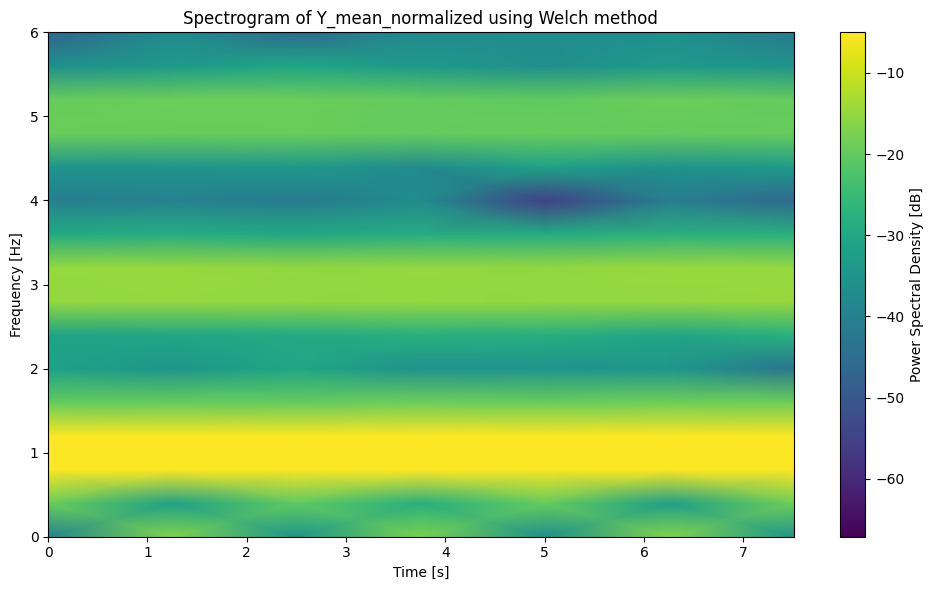

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Normalizar Y_mean al rango [-1, 1]
Y_mean_normalized = 2 * (Y_mean - np.min(Y_mean)) / (np.max(Y_mean) - np.min(Y_mean)) - 1

# Parámetros para Welch
nperseg = 256
noverlap = 128
fs = 1 / (t[1] - t[0])

# Número de segmentos
n_segments = (N - nperseg) // (nperseg - noverlap) + 1

# Inicializar arrays para almacenar resultados
frequencies = np.fft.fftfreq(nperseg, d=1/fs)[:nperseg//2]
times = np.arange(n_segments) * (nperseg - noverlap) / fs
Sxx = np.zeros((len(frequencies), n_segments))

# Calcular PSD usando Welch para cada segmento
for i in range(n_segments):
    start = i * (nperseg - noverlap)
    end = start + nperseg
    segment = Y_mean_normalized[start:end]
    f, Pxx = welch(segment, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nperseg)
    Sxx[:, i] = Pxx[:nperseg//2]

# Plotear el espectrograma
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of Y_mean_normalized using Welch method')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power Spectral Density [dB]')
plt.ylim([0, 6])  # Ajustar según el rango de frecuencias de interés
plt.tight_layout()
plt.show()

## Ejercicios:

Y es una matriz (N,M) N = 64 M = 32 y N = 1028 M = 256

1. Entrenar N.N. con entrada de Y y salida de vector de welch. Hallar mean_square_error

2. Entrenar N.N. con entrada de Y y salida de vector $R^3, [S(wo),S(3wo),S(5wo)]$

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

def randomatrix (N, M, media, varianza):
    return np.random.normal(media, np.sqrt(varianza), (N, M))

def real_signal (wo,t):
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

N = 1024
M = 512
media = 0
varianza = 0.1
wo = 2*np.pi

gaussmatrix = randomatrix(N,M,media,varianza)

t = np.linspace(0, 10, N)

Y = np.zeros((M, N))
for i in range(M):
    Y_true = real_signal(wo, t)
    Y[i] = Y_true + gaussmatrix[:,i]

Y_mean = np.mean(Y, axis=0)

- psd_mean = Welch a cada señal con ruido de la matriz y luego su promedio
- psd_m = Welch a la señal Y_mean

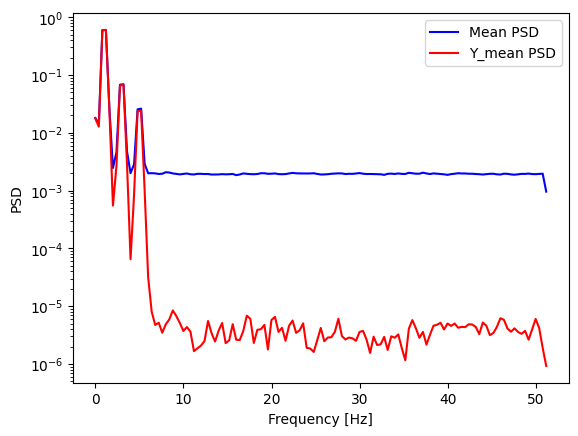

In [4]:
#WELCH
nperseg = 256
noverlap = 128
fs = 1 / (t[1] - t[0])

f, psd_m = welch(Y_mean, fs=fs, nperseg=nperseg, noverlap=noverlap)

psd_matrix = np.zeros((M, (nperseg//2)+1))
for i in range(M):
    f, psd = welch(Y[i], fs=fs, nperseg=nperseg, noverlap=noverlap)
    psd_matrix[i] = psd

psd_mean = np.mean(psd_matrix, axis=0)
plt.semilogy(f, psd_mean, color='b', label='Mean PSD')
plt.semilogy(f, psd_m, color='r', label='Y_mean PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.legend()
plt.show()

## Crear la red neuronal

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

def randomatrix (N, M, media, varianza):
    return np.random.normal(media, np.sqrt(varianza), (N, M))

def real_signal (wo,t):
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

N = 1024
M = 512
media = 0
varianza = 0.1
wo = 2*np.pi

gaussmatrix = randomatrix(N,M,media,varianza)

t = np.linspace(0, 10, N)

X = np.zeros((M, N))
for i in range(M):
    X_true = real_signal(wo, t)
    X[i] = X_true + gaussmatrix[:,i]

#WELCH
nperseg = 256
noverlap = 128
fs = 1 / (t[1] - t[0])


psd_matrix = np.zeros((M, (nperseg//2)+1))
for i in range(M):
    f, psd = welch(X[i], fs=fs, nperseg=nperseg, noverlap=noverlap)
    psd_matrix[i] = psd


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
psd_matrix = scaler.fit_transform(psd_matrix)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, psd_matrix, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(N,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=(nperseg//2)+1, activation='linear'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2165 - mean_absolute_error: 0.8684 
Test Loss: 1.2117913961410522, Test MAE: 0.8673285245895386
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


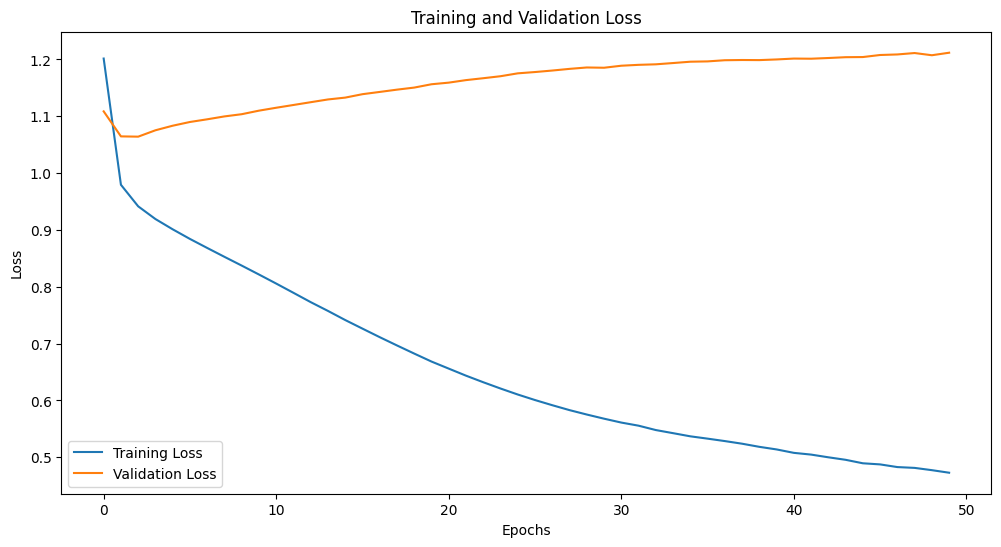

In [4]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
y_pred = model.predict(X_test)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Mean Square Error: 1.868181349270016e-08


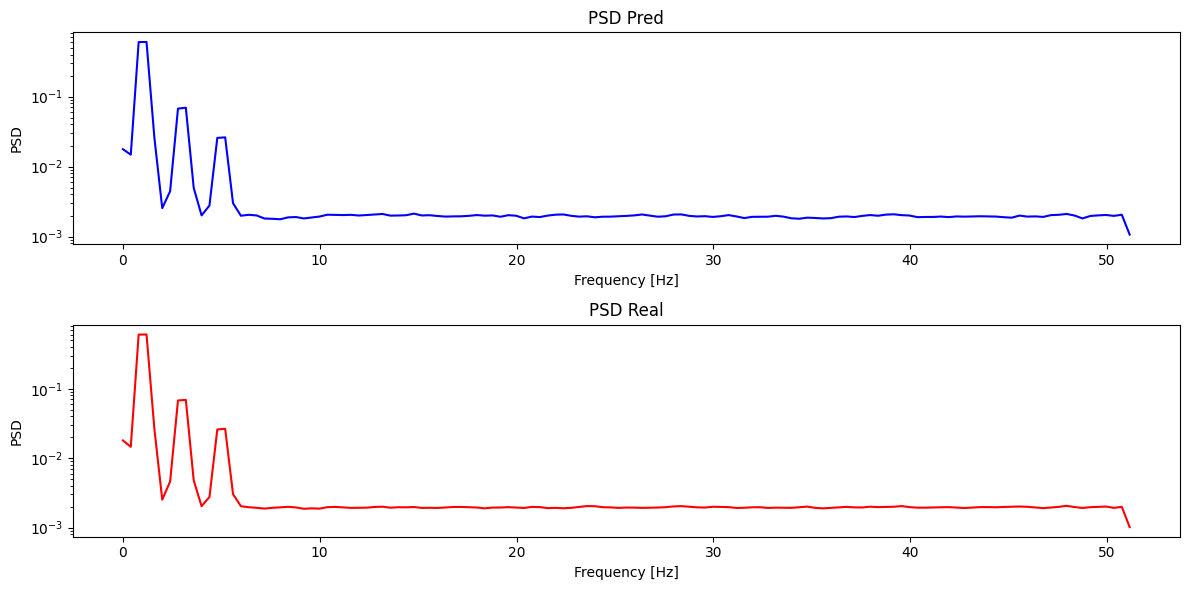

In [5]:
psd_pred = scaler.inverse_transform(y_pred)
psd_real = scaler.inverse_transform(psd_matrix)

psd_pred_mean = np.mean(psd_pred, axis=0)
psd_real_mean = np.mean(psd_real, axis=0)

mean_square_error = np.mean((psd_pred_mean - psd_real_mean)**2)
print("Mean Square Error:", mean_square_error)


fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].semilogy(f, psd_pred_mean, color='b')
ax[1].semilogy(f, psd_real_mean, color='r')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('PSD')
ax[0].set_title('PSD Pred')
ax[1].set_title('PSD Real')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('PSD')
plt.tight_layout()
plt.show()